### Overview

This project uses several sources related to movie releases and performance to define and analyze what makes a successful movie. It will display results that can be used in decision making for a movie studio creation venture for Microsoft.

### Data Sets and Parameters

For this analysis, I've chosen to use the 'The Numbers' data set to analyze budgets since it includes a fuller picture than some of the other options. For a qualitative look, I'll use IMDB to look at user reviews and Rotten Tomatoes to look at critic reviews.

These data sets use very different categorization & scoring methods, and have diffent data points. Therefore my methodology to analyze each will be unique, and I will treat them as separate sources. 

A quick note on some parameters: 
1. I will be looking at US data only to get a conststent picture of Microsoft's home market as a starting off point 
2. I'll be cleaning out older movies - since the movie industry & video consumption is changing so rapidly at this time, I want to examine only the most recent data

In [1]:
# First I am going to import all necessary libraries and data files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import budgets data
df_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', compression='gzip')

#import imdb data
df_imdb_basics = pd.read_csv('zippedData/imdb.title.basics.csv.gz', compression='gzip')
df_imdb_ratings = pd.read_csv('zippedData/imdb.title.ratings.csv.gz', compression='gzip')
df_imdb_akas = pd.read_csv('zippedData/imdb.title.akas.csv.gz', compression='gzip')

#import rotten tomatoes data
df_rt_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t', compression='gzip')
df_rt_rev = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', compression='gzip', encoding='iso-8859-1')

### Measures of Success 

So before I dive in, I'll outline my metrics for a successful movie:

1. __Positive return on investment:__ Because ultimately, a successful business venture makes money. 

2. __High user ratings:__ We want people to like the movie! This will (hopefully) help generate word-of-mouth promotion and social media chat to spread positive opinion. 

3. __High critical ratings:__ Strong critical reviews mean positive press, which will capture media attention. Having clout in the industry as well can mean getting put up for awards, which can be a great set up to draw in better talent to future films, and better funding from potential investors

First, I'll be looking at the movie budgets data. I want to see if I can get a sense of movies with highest return on investment. 

To do this, I need to convert the budget columns into integers and then add a column calculating return on investment. I am also going to clean out older movies, and add year and month columns so I can further analyze the data.

In [3]:
#convert to date time and add columns for month and year
df_budgets['release_date'] = pd.to_datetime(df_budgets['release_date'])
df_budgets['release_year'] = df_budgets['release_date'].dt.year
df_budgets['release_month'] = df_budgets['release_date'].dt.month
#clean out old movies
df_budgets = df_budgets[(df_budgets['release_year'] >= 2014)]

In [4]:
#make $$ columns into integers
df_budgets['production_budget'] = df_budgets['production_budget'].map(lambda price: int(price.replace("$", "").replace(",", "")))
df_budgets['domestic_gross'] = df_budgets['domestic_gross'].map(lambda price: int(price.replace("$", "").replace(",", "")))
df_budgets['worldwide_gross'] = df_budgets['worldwide_gross'].map(lambda price: int(price.replace("$", "").replace(",", "")))
#calculate ROI column
df_budgets['domestic_roi'] = df_budgets['domestic_gross'] / df_budgets['production_budget']

I'm going to examine ROI using the variables I have in this data set, which are release date-related. I'll create dataframes to look at ROI by month and year and plot the results. 

In [5]:
df_budgets.sort_values(['domestic_roi'], ascending = False).head(20)
df_roi = df_budgets.groupby(['release_year'])['domestic_roi'].mean()
df_roi = df_roi.reset_index()
# 2020 has no budget data in this set
df_roi = df_roi.drop(index = 6)
df_roi

,release_year,domestic_roi
0,2014,1.432386
1,2015,1.653406
2,2016,1.599537
3,2017,1.980350
4,2018,2.077434
5,2019,1.224815


In [6]:
df_roi_mo = df_budgets.groupby(['release_month'])['domestic_roi'].mean()
df_roi_mo = df_roi_mo.reset_index()
df_roi_mo.head(2)

,release_month,domestic_roi
0,1,1.620346
1,2,1.628038


AttributeError: 'AxesSubplot' object has no attribute 'gca'

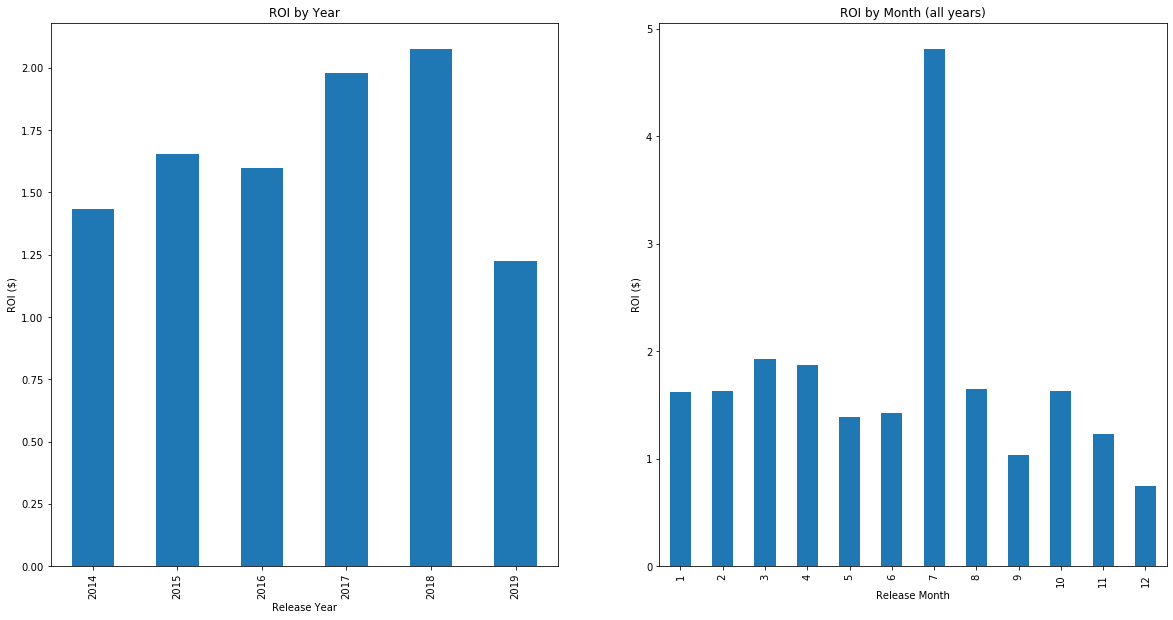

In [27]:
import matplotlib.ticker
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 2, 1)
df_roi.plot(x='release_year', y='domestic_roi', ax=ax1, kind = 'bar', legend = False)
ax1.set_title('ROI by Year')
ax1.set_xlabel('Release Year')
ax1.set_ylabel('ROI ($)')

ax2 = plt.subplot(1,2,2)
df_roi_mo.plot(x='release_month', y='domestic_roi', ax=ax2, kind = 'bar', legend = False)
ax2.set_title('ROI by Month (all years)')
ax2.set_xlabel('Release Month')
ax2.set_ylabel('ROI ($)')
ax2.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))


plt.show()

So it looks like July is a definite winner - likely because there are often big summer releases, but also because more people are off work/school. Let's aim for our first movie to come out in July. 

More nuanced is that 2017 and 2018 were good years for the industry. Let's take a look at some July movies first to see if we get a sense of any trends, then some top 2017-2018 releases

In [8]:
df_july_movies = df_budgets[df_budgets['release_month'] == 7].sort_values(['domestic_roi'], ascending = False)
# the highest movie on this list, 'The Gallows', is a major outlier with a low production budget and a ~$500 ROI so I am dropping it
df_july_movies = df_july_movies.drop([5679])

In [29]:
import plotly.express as px
fig = px.scatter(df_july_movies, x='production_budget', y='domestic_roi', hover_data=['movie'], width=800, height=500)
fig.update_layout(title='July Movies: ROI vs Budget',
    xaxis_title='Production Budget',
    yaxis_title='ROI ($)')
fig.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
fig.show()

AttributeError: 'Figure' object has no attribute 'yaxis'

The good news is, the majority of these movies have budgets on the lower end of this spread. To not get too risky, we can aim to start with a budget of ~50MM. These titles are diverse and contain horror, action, comedy and drama which gives us lots of options!

In [10]:
df_july_movies[df_july_movies['production_budget'] < 50000000].head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,domestic_roi
5685,86,2017-07-07,A Ghost Story,100000,1594798,2769782,2017,7,15.947980
4254,55,2016-07-22,Lights Out,5000000,67268835,148806510,2016,7,13.453767
5228,29,2018-07-20,Unfriended: Dark Web,1000000,8866745,16434588,2018,7,8.866745
3770,71,2014-07-18,The Purge: Anarchy,9000000,71562550,111534881,2014,7,7.951394
3541,42,2016-07-01,The Purge: Election Year,10000000,79042440,118514727,2016,7,7.904244
4894,95,2018-07-13,Eighth Grade,2000000,13539710,14341016,2018,7,6.769855
4484,85,2014-07-11,Boyhood,4000000,25379975,57273049,2014,7,6.344994
2498,99,2016-07-29,Bad Moms,20000000,113257297,180998716,2016,7,5.662865
4653,54,2018-07-06,Sorry to Bother You,3200000,17493096,18285560,2018,7,5.466592
3248,49,2018-07-04,The First Purge,13000000,69488745,136617305,2018,7,5.345288


In [11]:
df_good_years = df_budgets[(df_budgets['release_year'] == 2017) | (df_budgets['release_year'] == 2018)]
fig2 = px.scatter(df_good_years, x='production_budget', y='domestic_roi', hover_data=['movie'], width=800, height=600)
fig2.update_layout(title='2017-2018 Movies',
    xaxis_title='Production Budget',
    yaxis_title='ROI ($)')

fig.show()

So, similarly we get a diverse range of titles with most production budgets falling below $50k.

What if we took a different angle and didn't worry about budgets, but instead looked at what movies grosed the highest?

In [12]:
df_budgets.sort_values(['domestic_gross'], ascending = False).head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,domestic_roi
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,2015,12,3.060988
41,42,2018-02-16,Black Panther,200000000,700059566,1348258224,2018,2,3.500298
6,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,2018,4,2.262718
33,34,2015-06-12,Jurassic World,215000000,652270625,1648854864,2015,6,3.033817
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,12,1.956408
43,44,2018-06-15,Incredibles 2,200000000,608581744,1242520711,2018,6,3.042909
44,45,2016-12-16,Rogue One: A Star Wars Story,200000000,532177324,1049102856,2016,12,2.660887
134,35,2017-03-17,Beauty and the Beast,160000000,504014165,1259199706,2017,3,3.150089
45,46,2016-06-17,Finding Dory,200000000,486295561,1021215193,2016,6,2.431478
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,5,1.388403


These movies all are all pretty major franchises, and in many cases, remakes or sequels. Unless we want to purchase or start a major movie franchise on our first try, let's use 'July Movies' as our goal.

So to recap the recommendations from this data analysis, which answers success metric #1: 

__1. Release a movie in July for the biggest return on investment__

__2. Start with a budget below $50MM since most July movies with high returns fell at or below this.__

Now I'll move on to #2 and #3, and start working on the ratings data. First, I'm going to do some cleaning. 

In [13]:
#remove older years
df_filtered = df_imdb_basics[(df_imdb_basics['start_year'] <= 2020) & (df_imdb_basics['start_year'] >= 2014)]
#drop null values
df_filtered = df_filtered.dropna(subset=['genres'])
#drop titles with a low number of votes since there isn't statistical significance
df_imdb_ratings = df_imdb_ratings[(df_imdb_ratings['numvotes'] > 100)]

Now I am going to split out the genres into multiple columns.

In [14]:
df_filtered = df_filtered.dropna(subset=['genres'])
genres = df_filtered['genres'].str.split(",", n = 1, expand = True)
df_filtered['genre1']= genres[0]
df_filtered['genre2']= genres[1]
genres2 = df_filtered['genre2'].str.split(",", n = 1, expand = True)
df_filtered['genre2']= genres2[0]
df_filtered['genre3']= genres2[1]
df_filtered.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,genre1,genre2,genre3
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",Biography,Drama,None
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,Drama,None,None
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",Comedy,Drama,None
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",Comedy,Drama,Fantasy
5,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy,Comedy,None,None


I am choosing to use pandasql to join all the dataframes and make some queries about the data. First I'm joining the basics data with ratings, then I am joining the 'akas' data. Since I want to focus on US only data for this analysis this will help me filter out non-US market data.

In [15]:
from pandasql import sqldf
pysqldf =  lambda q: sqldf(q, globals())
q = '''SELECT *
        FROM df_filtered
        JOIN df_imdb_ratings
        USING(tconst)
        ;'''

imdb_joined_df = pysqldf(q)
imdb_joined_df.head(2)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,genre1,genre2,genre3,averagerating,numvotes
0,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,Drama,None,None,6.9,4517
1,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",Comedy,Drama,Fantasy,6.5,119


In [16]:
q = '''SELECT *
        FROM imdb_joined_df
        JOIN df_imdb_akas
        ON df_imdb_akas.title_id = imdb_joined_df.tconst
        ;'''

imdb_all = pysqldf(q)
imdb_all.head(2)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,genre1,genre2,genre3,averagerating,numvotes,title_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,Drama,None,None,6.9,4517,tt0069049,1,O Outro Lado do Vento,BR,None,imdbDisplay,None,0.0
1,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,Drama,None,None,6.9,4517,tt0069049,2,The Other Side of the Wind,US,None,imdbDisplay,None,0.0


In [17]:
#filter to US only
imdb_all = imdb_all[imdb_all['region'] == 'US']
#there are duplicates coming up so I'll drop those
imdb_all = imdb_all.drop_duplicates(subset = 'tconst')

Next I'm working through my rating-by-genre calculation. I'll need a list of all the genres. 

First, I have a function that loops through all three genre columns, and creates a list of ratings for a given genre. It then outputs the average rating.

In [31]:
#get a list of all the genres
genres_list = list(imdb_all['genre1'].unique())

In [32]:
def avg_rating_by_genre(genre):
    averagerating_list = []
    for row in imdb_all.index:
        if (imdb_all['genre1'][row] == genre) | (imdb_all['genre2'][row] == genre) | (imdb_all['genre2'][row] == genre):
            averagerating_list.append(imdb_all['averagerating'][row])
    return np.mean(averagerating_list)

I want to see the averages for all in one place, so I will use the unique genres list to format that into a dictionary. To make it easier to plot, I'm going to convert this into a dataframe and order it. 

In [33]:
# link average rating to each genre in my list using a dictionary
genre_dict = {}
for genre in genres_list:
    value = avg_rating_by_genre(genre)
    key = genre 
    genre_dict[key] = value

In [34]:
genre_df = pd.DataFrame(list(genre_dict.items()),columns = ['Genre','Average Rating']) 
genre_df = genre_df.sort_values('Average Rating', ascending = False)

(0, 10)

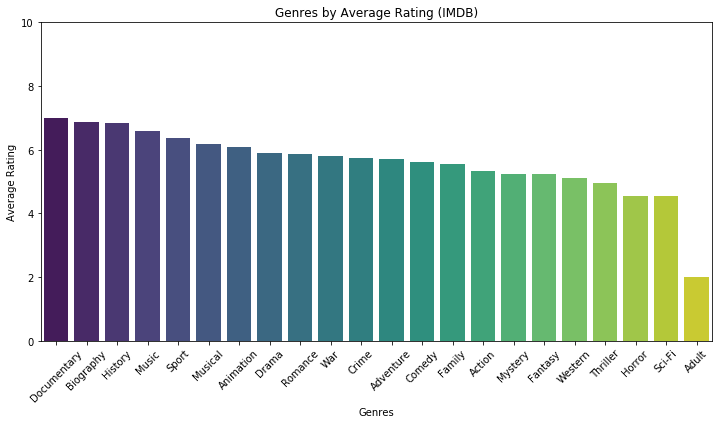

In [35]:
plt.figure (figsize=(10,6))
ax = sns.barplot(x=genre_df['Genre'], y=genre_df['Average Rating'], palette='viridis')
plt.title('Genres by Average Rating (IMDB)')
plt.xlabel('Genres')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylim(0, 10)

Interestingly, non-fiction genres like Biography, Documentary, History & Sport look to have highest ratings. Another contender is music/musical. 

So in response to question #2: __We should consider a non-fiction subject, maybe a profile of a musician or athlete that is relevant right now.__

Note: I also took a look at the relationship between runtime and ratings, and didn't find any conclusive results. My recommendation would be to aim for a close to average runtime when working on movie parameters. The mean runtime looks to be 97 minutes with a standard deviation on the lower end, so between 1.5 and 2 hours is a good range to keep in mind.

In [24]:
print(imdb_all['runtime_minutes'].mean())
print(imdb_all['runtime_minutes'].std())

97.15842894969109
18.71284901507976


Finally, to get a complete picture, I'll look at the Rotten Tomatoes data sets. 

I want to join review data to the movie data, but this would be a many-to-one join and would make an extremely large and unworkable merge. Therefore, I am creating an indicator of average review positivity for each movie so I can add columns to the rt_info dataframe. After previewing the 'rating' column, I can see that the scale of ratings is different in many instances, and some are numerical while some are not. Since it would be pretty messy to try and make this column workable, I am instead going to use the 'fresh' column to get a percentage of overall positive reviews. 

In [41]:
# insert a new column with a value of zero 
df_rt_rev['fresh_ind'] = 0

# loop through the data and input a 1 where the rating is 'fresh'
for row in df_rt_rev.index:
    if df_rt_rev['fresh'][row] == 'fresh':
        df_rt_rev['fresh_ind'][row] = 1

In [42]:
# pivot the data to look at aggregate values by movie: total ratings (count), and total positive ratings (sum)
df_grouped = df_rt_rev.groupby(['id'])['fresh_ind'].agg(['count', 'sum'])

#insert a column to get a % of total positive reviews
df_grouped['fresh_pct'] = df_grouped['sum'] / df_grouped['count']
df_grouped.reset_index()
df_grouped.head(2)

,count,sum,fresh_pct
id,,,
3,163,103,0.631902
5,23,18,0.782609


In [43]:
# now I can merge the dataframes using the movie ID
rt_all = pd.merge(df_rt_info, df_grouped, how='inner', on='id')

My dataframes are merged with a 'ratings' indicator, so now I am going to clean up the data. I'll then split the genres into separate columns similar to what I did for the IMDB data, then write a similar loop function to get an average by genre. 

In [92]:
#create a column for release year by changing the current dates to datetime and separating
rt_all['theater_date'] = pd.to_datetime(rt_all['theater_date'])
rt_all['release_year'] = rt_all['theater_date'].dt.year

#fill nas so I can work with the data
rt_all['release_year'] = rt_all['release_year'].fillna(0)

#dates are coming up as floats so I am changing them to integers
rt_all = rt_all.astype({'release_year': 'int64'})

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1135 entries, 0 to 1134
Data columns (total 16 columns):
id              1135 non-null int64
synopsis        1118 non-null object
rating          1134 non-null object
genre           1133 non-null object
director        1014 non-null object
writer          891 non-null object
theater_date    996 non-null datetime64[ns]
dvd_date        996 non-null object
currency        299 non-null object
box_office      299 non-null object
runtime         1123 non-null object
studio          415 non-null object
count           1135 non-null int64
sum             1135 non-null int64
fresh_pct       1135 non-null float64
release_year    1135 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(10)
memory usage: 150.7+ KB


In [93]:
# filter out older movies
rt_filtered = rt_all[(rt_all['release_year'] >= 2010)]
rt_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 0 to 1123
Data columns (total 16 columns):
id              160 non-null int64
synopsis        160 non-null object
rating          160 non-null object
genre           160 non-null object
director        147 non-null object
writer          138 non-null object
theater_date    160 non-null datetime64[ns]
dvd_date        160 non-null object
currency        114 non-null object
box_office      114 non-null object
runtime         154 non-null object
studio          128 non-null object
count           160 non-null int64
sum             160 non-null int64
fresh_pct       160 non-null float64
release_year    160 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(10)
memory usage: 21.2+ KB


In [47]:
genres = rt_filtered['genre'].str.split("|", n = 1, expand = True)
rt_filtered['genre1']= genres[0]
rt_filtered['genre2']= genres[1]
genres2 = rt_filtered['genre2'].str.split("|", n = 1, expand = True)
rt_filtered['genre2']= genres2[0]
rt_filtered['genre3']= genres2[1]
rt_filtered.head(2)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,count,sum,fresh_pct,release_year,genre1,genre2,genre3
0,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,"Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,163,103,0.631902,2012,Drama,Science Fiction and Fantasy,None
6,14,"""Love Ranch"" is a bittersweet love story that ...",R,Drama,Taylor Hackford,Mark Jacobson,2010-06-30,"Nov 9, 2010",$,"134,904",117 minutes,NaN,42,6,0.142857,2010,Drama,None,None


In [48]:
#get a list of all genres - the first 2 columns cover them all
genrelist1 = list(rt_filtered['genre1'].unique())
genrelist2 = list(rt_filtered['genre2'].unique())
genrelist_all = set(genrelist1 + genrelist2)

In [49]:
def avg_rating_by_genre_rt(genre):
    genre_counts = []
    genre_sums = []
    for row in rt_filtered.index:
        if (rt_filtered['genre1'][row] == genre) | (rt_filtered['genre2'][row] == genre) | (rt_filtered['genre2'][row] == genre):
            genre_counts.append(rt_filtered['count'][row])
            genre_sums.append(rt_filtered['sum'][row])
   
    # I need to recalculate the average

    genreavg = (sum(genre_sums) / sum(genre_counts))
    return genreavg

In [51]:
genre_dict_rt = {}
for genre in genrelist_all:
    value = avg_rating_by_genre_rt(genre)
    key = genre 
    genre_dict_rt[key] = value
genre_dict_rt

{'Action and Adventure': 0.5514285714285714,
 'Horror': 0.5098039215686274,
 'Science Fiction and Fantasy': 0.47297297297297297,
 'Sports and Fitness': 0.688,
 'Mystery and Suspense': 0.6157007809288944,
 'Animation': 0.6402366863905326,
 'Musical and Performing Arts': 0.39672131147540984,
 'Kids and Family': 0.539568345323741,
 'Drama': 0.6926089084679393,
 'Documentary': 0.9076923076923077,
 None: 0.6606098909780376,
 'Romance': 0.7539556962025317,
 'Western': 0.3275862068965517,
 'Special Interest': 0.4,
 'Comedy': 0.6409075961854653,
 'Art House and International': 0.7368421052631579}

In [52]:
# I'm making this into a dataframe and cleaning it up
genre_df_rt = pd.DataFrame(list(genre_dict_rt.items()),columns = ['Genre','Average Fresh Score']) 
genre_df_rt = genre_df_rt.sort_values('Average Fresh Score', ascending = False)
genre_df_rt = genre_df_rt.reset_index()

In [53]:
# I am getting a 'none' genre so I need to remove that
genre_df_rt = genre_df_rt.dropna()
genre_df_rt

,index,Genre,Average Fresh Score
0,9,Documentary,0.907692
1,11,Romance,0.753956
2,15,Art House and International,0.736842
3,8,Drama,0.692609
4,3,Sports and Fitness,0.688000
6,14,Comedy,0.640908
7,5,Animation,0.640237
8,4,Mystery and Suspense,0.615701
9,0,Action and Adventure,0.551429
10,7,Kids and Family,0.539568


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

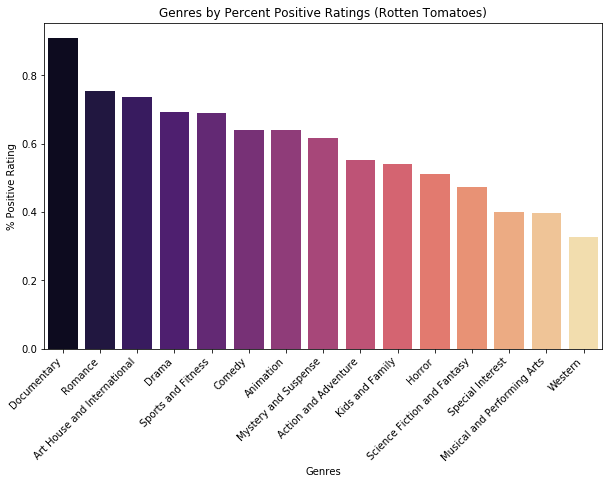

In [54]:
plt.figure (figsize=(10,6))
ax = sns.barplot(x=genre_df_rt['Genre'], y=genre_df_rt['Average Fresh Score'], palette='magma')
plt.title('Genres by Percent Positive Ratings (Rotten Tomatoes)')
plt.xlabel('Genres')
plt.ylabel('% Positive Rating')
plt.xticks(rotation = 45, horizontalalignment="right")

While the methodology is pretty different here, it looks like documentaries are still the top rated genre. However, music looks like it's on the lower end compared to IMDB rankings. Let's consider the second, third, and fourth result. While Romance and Drama weren't in the top categories in the IMDB data, they were still above average. Art House and International is a pretty vague category, but may recall some of our top revenue-driving movies with lower budgets from the budgets data.

These are critical ratings, so we have to keep in mind a possible bias towards more 'serious' genres. Also, this data set is notably much smaller than our IMDB one, due to this data primarily consisting of older movies

In [91]:
print(len(rt_filtered.loc[(rt_filtered['genre1'] =='Documentary') | (rt_filtered['genre2'] =='Documentary')| (rt_filtered['genre2'] =='Documentary')]))
print(len(rt_filtered.loc[(rt_filtered['genre1'] =='Romance') | (rt_filtered['genre2'] =='Romance')| (rt_filtered['genre2'] =='Romance')]))

4
12
